**Reference Article**  
*[Continuous Kalman Estimation Method for Finger Kinematics Tracking from Surface Electromyography](https://www.researchgate.net/publication/377379296_Continuous_Kalman_Estimation_Method_for_Finger_Kinematics_Tracking_from_Surface_Electromyography)*  
DOI:10.34133/cbsystems.0094

**Dataset**  
Ninapro DB8: https://ninapro.hevs.ch/instructions/DB8.html



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from scipy.io import loadmat
import os
import mne


# Load subjects

In [2]:
df_subjects = pd.read_csv('DB8/Ninapro_DB8_SubjectsInformation.csv', index_col=0).sort_index()
# df_subjects.head()
df_subjects.rename(columns=dict(zip(df_subjects.columns[-3:], ['A1', 'A2', 'A3'])), inplace=True)
df_subjects.iloc[:,-3:] = 'DB8/'+df_subjects.iloc[:,-3:]

df_subjects

,Age,Gender,LateralityNew,Height,Weight,Forearm Circumference,Hand Amputation,Remaining Forearm (%),Years passed by the amputation,Amputation cause,Use of cosmetic prosthesis (Years),Use of kinematic prosthesis (Years),Use of myoelectric prosthesis (Years),A1,A2,A3
Title,,,,,,,,,,,,,,,,
1,27,Male,Right Handed,180,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S1_E1_A1.mat,DB8/S1_E1_A2.mat,DB8/S1_E1_A3.mat
2,26,Male,Right Handed,180,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S2_E1_A1.mat,DB8/S2_E1_A2.mat,DB8/S2_E1_A3.mat
3,34,Male,Right Handed,185,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S3_E1_A1.mat,DB8/S3_E1_A2.mat,DB8/S3_E1_A3.mat
4,29,Female,Right Handed,180,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S4_E1_A1.mat,DB8/S4_E1_A2.mat,DB8/S4_E1_A3.mat
5,34,Female,Right Handed,172,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S5_E1_A1.mat,DB8/S5_E1_A2.mat,DB8/S5_E1_A3.mat
6,24,Male,Right Handed,180,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S6_E1_A1.mat,DB8/S6_E1_A2.mat,DB8/S6_E1_A3.mat
7,26,Male,Right Handed,183,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S7_E1_A1.mat,DB8/S7_E1_A2.mat,DB8/S7_E1_A3.mat
8,29,Male,Right Handed,178,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S8_E1_A1.mat,DB8/S8_E1_A2.mat,DB8/S8_E1_A3.mat
9,24,Male,Right Handed,183,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB8/S9_E1_A1.mat,DB8/S9_E1_A2.mat,DB8/S9_E1_A3.mat


## Macro Parameters



In [3]:
sfreq = 2000 # Hz, by description

win_s  = 0.1 # s
win_step_s = win_s

win_n  = int(win_s * sfreq) # number of samples
win_step_n = int(win_step_s * sfreq)

glv_channels = np.array([1,2,6,8,11,14])-1 # kinematics montage
glv_names = ['ThumbRot', 'ThumbFlex', 'Index', 'Middle', 'Ring', 'Pinky']



# Single Record Studies

In [4]:
mat = loadmat(df_subjects.loc[10, 'A1'])

In [5]:
list(mat.keys())

['__header__',
 '__version__',
 '__globals__',
 'subject',
 'exercise',
 'emg',
 'acc',
 'gyro',
 'mag',
 'glove',
 'stimulus',
 'repetition',
 'restimulus',
 'rerepetition']

In [6]:
def preprocess(mat):
    """
    Processes the EMG and glove data from the input matrix 'mat'.
    
    The function performs the following operations:
    1. Filters the EMG data between 60-300 Hz using a minimum-phase filter.
    2. Calculates the envelope of the EMG data using the Mean Absolute Value (MAV) method.
    3. Extracts and processes the glove data corresponding to specific channels.
    4. Computes the new sampling frequency and constructs a time series.

    Parameters:
        mat (dict): A dictionary containing 'emg' and 'glove' data matrices.

    Returns:
        tuple: A tuple containing:
            - env (numpy.ndarray): The envelope of the EMG data.
            - glv (numpy.ndarray): The processed glove data.
            - ts (numpy.ndarray): The time series corresponding to the data.
            - new_sfreq (float): The new sampling frequency after processing.
    """
    SFREQ = 2000 # by description

    # Extract EMG data and apply band-pass filter
    emg = mat['emg']
    emg[:] = mne.filter.filter_data(emg.T.astype('float64'), SFREQ, 60, 300, verbose=False, phase='minimum').T 

    # Calculate the envelope of the EMG data using Mean Absolute Value (MAV)
    emg_splits = np.array_split(emg, axis=0, indices_or_sections=np.arange(win_n, len(emg), win_n))[:-1]
    env = np.stack([np.mean(np.abs(x), axis=0) for x in emg_splits], axis=0)

    # Process glove data for selected channels
    glove = mat['glove'][:, glv_channels]
    glv_splits = np.array_split(glove, axis=0, indices_or_sections=np.arange(win_n, len(glove), win_n))[:-1]
    glv = np.stack([np.mean(np.abs(x), axis=0) for x in glv_splits], axis=0)

    # Calculate new sampling frequency and create time series
    new_sfreq = 1 / win_step_s
    ts = np.arange(len(env)) / new_sfreq

    return env, glv, ts, new_sfreq

env, glv, ts, new_sfreq = preprocess(mat); print(env.shape, glv.shape)

(11331, 16) (11331, 6)


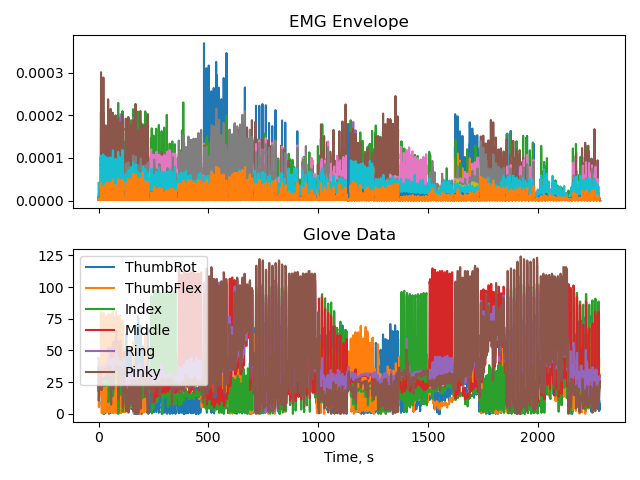

In [39]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ts, env)
axs[0].set_title('EMG Envelope')

axs[1].plot(ts, glv)
axs[1].set_title('Glove Data')
axs[1].legend(glv_names)
plt.xlabel('Time, s')

plt.tight_layout()

## Notation

*State* — Finger Kinematics (here = absolute position)  
$X = [x_1,x_2,...,x_M]$ — state vector, $x_k$ is the state of the $k$-th timestamp (M - total number of timestamps)  
$x_k$ shape = $n_x,1$  

*Measurement* — EMG Envelope  
$Z = [z_1,z_2,...,z_M]$ — measurement vector, $z_k$ is the measurement of the $k$-th timestamp (M - total number of timestamps)  
$z_k$ shape = $n_z,1$  



### Construct State Vector and Measurement Vector

In [8]:
# State vector
print('State vectors')
X   = glv.copy().T; print(X.shape)

# Measurement Vector 
print('Measurement vector')
Z = env.copy().T; print(Z.shape)

State vectors
(6, 11331)
Measurement vector
(16, 11331)


### First. Why not just a linear model?

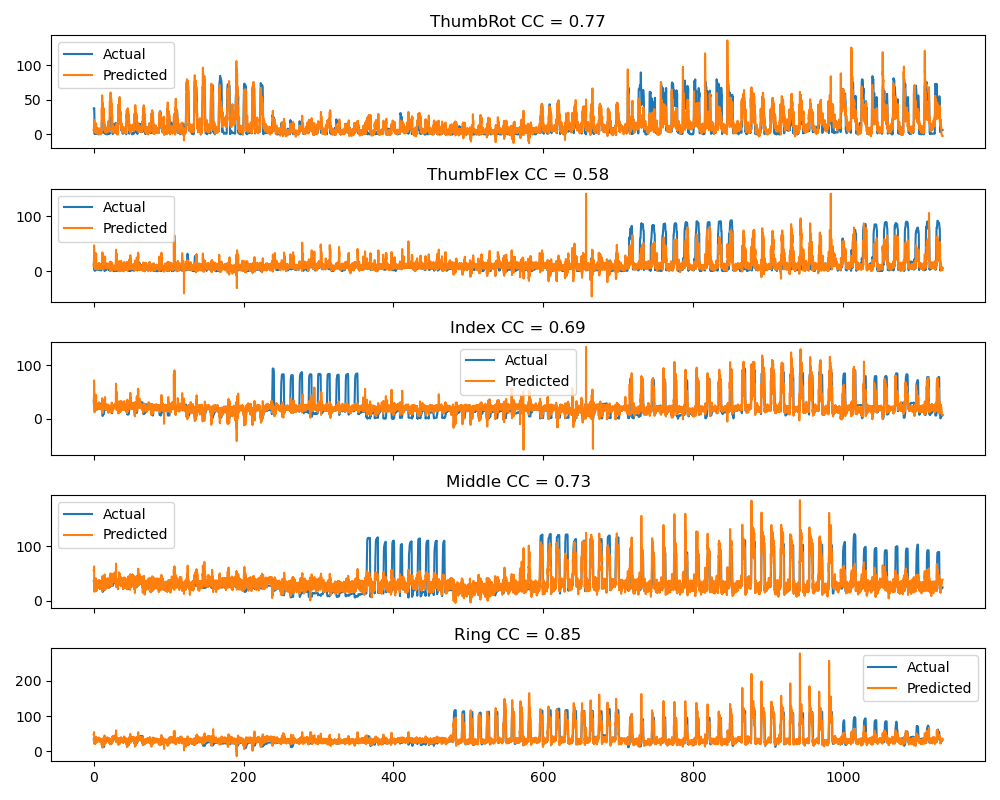

In [13]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(Z.T, X.T)
X_predicted = lr.predict(Z.T).T

from scipy.stats import pearsonr
CC = [pearsonr(x, x_pred).correlation for x, x_pred in zip(X, X_predicted)]

fig, axs = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
for i in range(5):
    axs[i].plot(ts, X[i, :].T, label='Actual')
    axs[i].plot(ts, X_predicted[i, :].T, label='Predicted')
    
    axs[i].legend()
    axs[i].set_title(f'{glv_names[i]} CC = {CC[i]:.2f}')

plt.tight_layout()



### Transition (A; F) and Measurement Matrices (H)

(5) $A = X_2 X_1^T(X_1 X_1^T)^{-1}$, shape = $(n_x, n_x)$  
(6) $H = Z X^T (X X^T)^{-1}$, shape = ($n_z$, $n_x$)

$X_1 = [x_1,x_2,...,x_{M-1}]$  
$X_2=[x_2,x_3,...,x_M]$




In [14]:
X_1 = X[:,:-1];     print(X_1.shape)
X_2 = X[:, 1:];     print(X_2.shape)

(6, 11330)
(6, 11330)


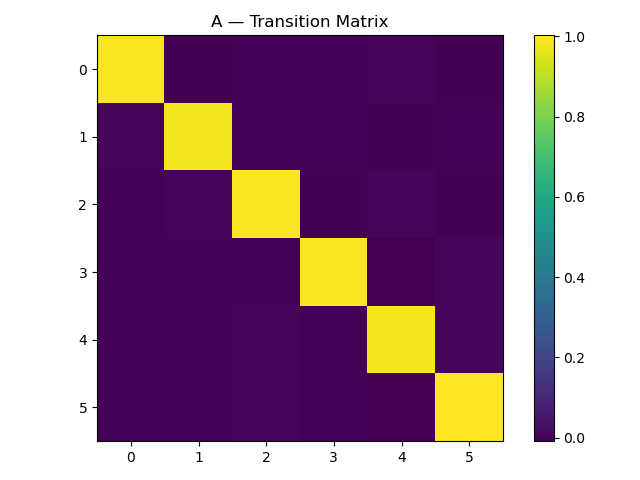

In [15]:


A = np.dot(np.dot(X_2, X_1.T), (np.linalg.inv(np.dot(X_1, X_1.T))))
plt.figure()
plt.imshow(A)
plt.colorbar()
plt.title('A — Transition Matrix')
plt.tight_layout()


### Measurement

(16, 6)


Text(0.5, 1.0, 'H — Measurement Matrix')

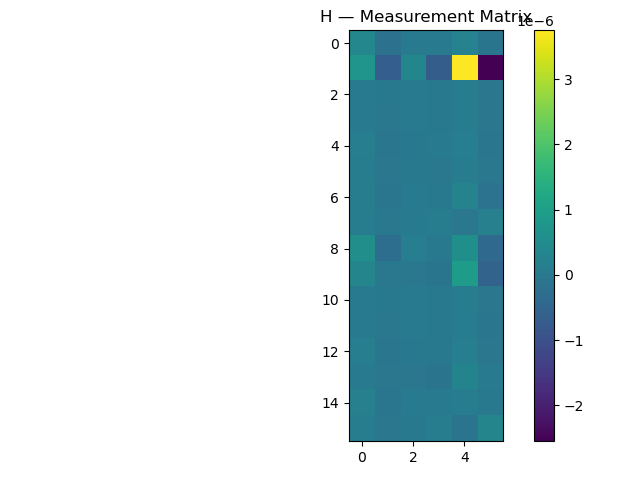

In [16]:
H = np.dot(np.dot(Z, X.T), (np.linalg.inv(np.dot(X, X.T)))); print(H.shape)
plt.figure()
plt.imshow(H)
plt.colorbar()
plt.tight_layout()
plt.title('H — Measurement Matrix')

## Noise  
State extrapolation variation:  
(7) $W = (X_2 - A X_1)(X_2 - A X_1)^T/(M-1)$  
Measurement variation:  
(8) $Q = (Z - H X)(Z - H X)^T/(M)$  



Text(0.5, 1.0, 'W — State Extrapolation Variation')

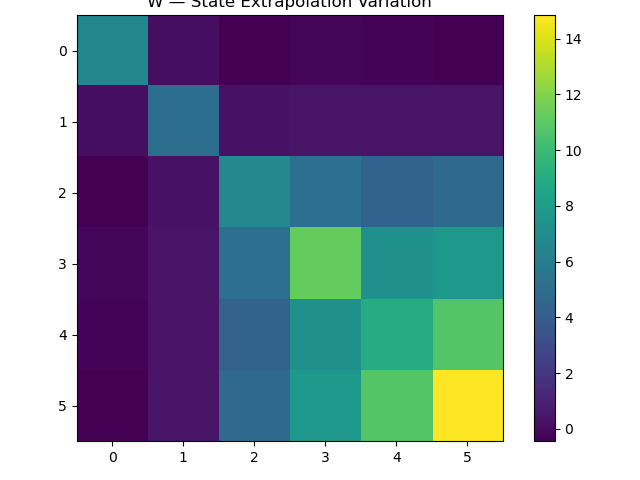

In [17]:
W = np.dot((X_2 - np.dot(A, X_1)), (X_2 - np.dot(A, X_1)).T) / (X.shape[1]-1)
plt.figure()
plt.imshow(W)
plt.colorbar()
plt.tight_layout()
plt.title('W — State Extrapolation Variation')




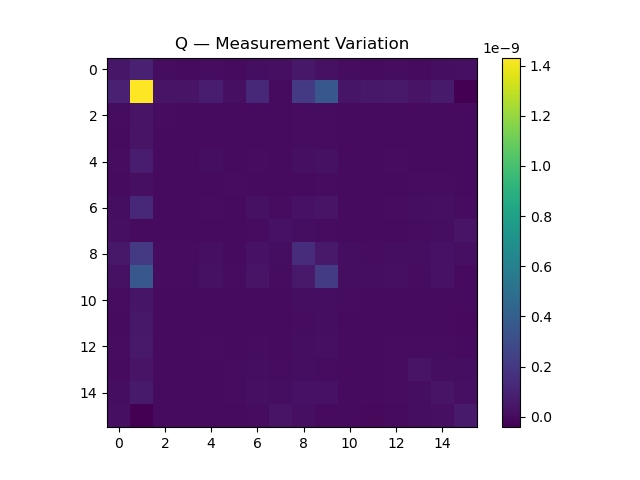

In [18]:
Q = np.dot((Z - np.dot(H, X)), (Z - np.dot(H, X)).T) / Z.shape[1]
plt.figure()
plt.imshow(Q)
plt.title('Q — Measurement Variation')
plt.colorbar()



## Extrapolation functions

State Extrapolation:  
(9) $\hat{X}_{k,k-1} = A \hat{X}_{k-1,k-1}$  

Variation Extrapolation:  
(10) $P_{k,k-1} = A P_{k-1,k-1} A^T + W$



In [19]:
X_extrapolation = lambda x: np.dot(A, x)
P_extrapolation = lambda p: np.dot(np.dot(A, p), A.T) + W

## Update functions

Kalman Gain:   
(11) $K_k = P_{k,k-1} H^T (H P_{k,k-1} H^T + Q)^{-1}$

State Update:  
(12) $\hat{X}_{k,k} = \hat{X}_{k,k-1} + K_k (Z_k - H \hat{X}_{k,k-1})$

Variation Update:  
(13) $P_{k,k} = (I - K_k H) P_{k,k-1}$


In [20]:
K_gain = lambda p: p.dot((H.T).dot(np.linalg.inv(H.dot(p).dot(H.T) + Q)))
X_update = lambda x, K, z: x + K.dot(z - H.dot(x))
P_update = lambda p, K: (np.eye(p.shape[0]) - K.dot(H)).dot(p)

## Sliding Filtering (Autovalidation)

In [21]:
# Initial states
x_hat = X[:, [0]]; print(x_hat.shape)
p = np.diag(X.std(axis=1)); print(p.shape)

(6, 1)
(6, 6)


In [22]:
X_predicted = np.zeros_like(X) # where we store the predicted states
X_predicted[:, [0]] = x_hat
for iz in range(1, len(Z.T)):

    # Measurement
    z = Z[:, [iz]] # The only source of incoming information

    # Extrapolation step
    x_hat_extrap = X_extrapolation(x_hat)
    p_extrap = P_extrapolation(p)

    # Update step
    K = K_gain(p_extrap)
    x_hat = X_update(x_hat_extrap, K, z)
    p = P_update(p_extrap, K)

    # Store predicted state
    X_predicted[:, [iz]] = x_hat



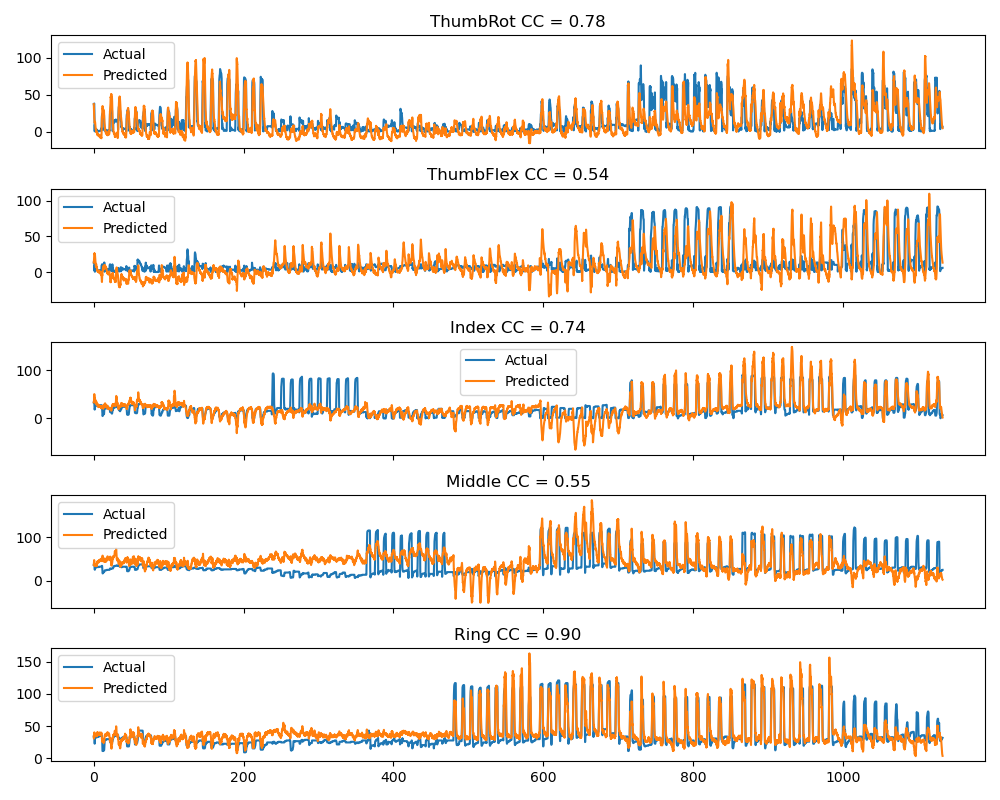

In [23]:
from scipy.stats import pearsonr
CC = [pearsonr(x, x_pred).correlation for x, x_pred in zip(X, X_predicted)]

fig, axs = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
for i in range(5):
    axs[i].plot(ts, X[i, :].T, label='Actual')
    axs[i].plot(ts, X_predicted[i, :].T, label='Predicted')
    
    axs[i].legend()
    axs[i].set_title(f'{glv_names[i]} CC = {CC[i]:.2f}')

plt.tight_layout()

# Group analysis

In [26]:
# Inherit functions from the single record analysis

# State and Variance Extrapolation Functions
X_extrapolation = lambda x: np.dot(A, x)
P_extrapolation = lambda p: np.dot(np.dot(A, p), A.T) + W

# State and Variance Update Functions
K_gain = lambda p: p.dot((H.T).dot(np.linalg.inv(H.dot(p).dot(H.T) + Q)))
X_update = lambda x, K, z: x + K.dot(z - H.dot(x))
P_update = lambda p, K: (np.eye(p.shape[0]) - K.dot(H)).dot(p)

In [28]:
from tqdm.autonotebook import tqdm

totalCC = {} # for storing performance values
totalCC_lr = {} # for storing performance values

for row_id, row in tqdm(df_subjects.iterrows(), total=len(df_subjects)):

    mat1 = loadmat(row['A1'])
    mat2 = loadmat(row['A2'])
    mat3 = loadmat(row['A3'])

    # Train set
    env1, glv1, ts1, new_sfreq = preprocess(mat1)
    env2, glv2, ts2, _         = preprocess(mat2)

    # Test Set
    env3, glv3, ts3, _         = preprocess(mat3)

    # Exclude empty channels: 11 patient has failed channels
    mask = mat3['emg'][:10000].std(0)>1e-8
    env1 = env1[:, mask]
    env2 = env2[:, mask]
    env3 = env3[:, mask]

    # Concatenate Train
    env = np.concatenate((env1, env2), axis=0)
    glv = np.concatenate((glv1, glv2), axis=0)
    ts = np.arange(len(env))/new_sfreq
    del env1, env2, glv1, glv2

    #### [Construct State and Measurement Vectors for Training]
    X = glv.copy().T; #print(X.shape)
    X_1 = X[:,:-1]; #print(X_1.shape)
    X_2 = X[:, 1:]; #print(X_2.shape)
    Z = env.copy().T; #print(Z.shape)
    #### [/Construct State and Measurement Vectors for Training]

    #### [Kalman Filter Training]
    # This is the only time the training data is used
    # Construct Transmission and Measurement Matrices
    A = np.dot(np.dot(X_2, X_1.T), (np.linalg.inv(np.dot(X_1, X_1.T))))
    H = np.dot(np.dot(Z, X.T), (np.linalg.inv(np.dot(X, X.T))));

    # Construct Noise Matrices
    W = np.dot((X_2 - np.dot(A, X_1)), (X_2 - np.dot(A, X_1)).T) / (X.shape[1]-1)
    Q = np.dot((Z - np.dot(H, X)), (Z - np.dot(H, X)).T) / Z.shape[1]

    # compare with linear regression later
    lr = LinearRegression()
    lr.fit(Z.T, X.T)

    # remove training data from context
    del X, Z, X_1, X_2 
    #### [/Kalman Filter Training]

    #### [Construct State and Measurement Vectors for Testing]
    X_test = glv3.copy().T 
    Z_test = env3.copy().T
    #### [/Construct State and Measurement Vectors for Testing]

    #### [linear regression]
    X_predicted = lr.predict(Z_test.T).T
    CC = np.array([pearsonr(x, x_pred).correlation 
                    for x, x_pred in zip(X_test, X_predicted)])
    print('LR', row_id, CC.round(2))
    totalCC_lr[row_id] = CC.copy()
    #### [/linear regression]

    #### [Perform Kalman Filtering on Test Data]
    # Initial States
    x_hat = X_test[:, [0]];
    p = np.diag(X_test.std(axis=1));

    # Launch Filtering
    X_predicted = np.zeros_like(X_test) # where we store the predicted states
    X_predicted[:, [0]] = x_hat
    for iz in range(1, len(Z_test.T)):
        # Measurement
        z = Z_test[:, [iz]] # The only source of incoming information

        # Extrapolation step
        x_hat_extrap = X_extrapolation(x_hat)
        p_extrap = P_extrapolation(p)

        # Update step
        K = K_gain(p_extrap)
        x_hat = X_update(x_hat_extrap, K, z)
        p = P_update(p_extrap, K)

        # Store predicted state
        X_predicted[:, [iz]] = x_hat
    #### [/Perform Kalman Filtering on Test Data]

    # Measure Performance using Pearson Correlation coefficient
    CC = np.array([pearsonr(x, x_pred).correlation 
          for x, x_pred in zip(X_test, X_predicted)])
    print('KF', row_id, CC.round(2))
    totalCC[row_id] = CC.copy()

    #### [Visualize]
    # fig, axs = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
    # for i in range(5):
    #     axs[i].plot(ts, X[i, :].T, label='Actual')
    #     axs[i].plot(ts, X_predicted[i, :].T, label='Predicted')
        
    #     axs[i].legend()
    #     axs[i].set_title(f'{glv_names[i]} CC = {CC[i]:.2f}')

    # plt.tight_layout()
    #### [/Visualize]

    # break

    # cleanup Kalman parameters
    del A, H, Q, W
    del X_predicted, x_hat, p



  0%|          | 0/12 [00:00<?, ?it/s]

LR 1 [0.69 0.57 0.44 0.52 0.61 0.59]
KF 1 [0.76 0.49 0.57 0.59 0.62 0.66]
LR 2 [0.71 0.34 0.63 0.76 0.86 0.85]
KF 2 [0.66 0.28 0.7  0.81 0.89 0.84]
LR 3 [0.68 0.41 0.46 0.71 0.64 0.61]
KF 3 [0.74 0.56 0.47 0.78 0.76 0.77]
LR 4 [0.6  0.55 0.74 0.71 0.86 0.84]
KF 4 [0.54 0.54 0.78 0.7  0.89 0.88]
LR 5 [0.59 0.46 0.32 0.64 0.6  0.72]
KF 5 [0.41 0.1  0.19 0.67 0.63 0.79]
LR 6 [0.62 0.55 0.57 0.56 0.75 0.71]
KF 6 [0.64 0.68 0.53 0.49 0.79 0.64]
LR 7 [0.6  0.7  0.67 0.73 0.76 0.76]
KF 7 [0.66 0.69 0.71 0.78 0.8  0.82]
LR 8 [0.56 0.66 0.52 0.59 0.74 0.75]
KF 8 [0.55 0.68 0.58 0.6  0.87 0.86]
LR 9 [0.57 0.52 0.65 0.64 0.67 0.69]
KF 9 [0.6  0.62 0.72 0.72 0.64 0.65]
LR 10 [0.68 0.65 0.67 0.72 0.84 0.86]
KF 10 [0.73 0.61 0.71 0.74 0.93 0.95]
LR 11 [0.7  0.67 0.55 0.66 0.72 0.69]
KF 11 [0.74 0.56 0.59 0.66 0.83 0.76]
LR 12 [0.33 0.53 0.56 0.49 0.54 0.57]
KF 12 [0.49 0.56 0.61 0.56 0.59 0.62]


In [31]:
df_stats_lr = pd.DataFrame(totalCC_lr, index = glv_names).T
df_stats_lr

,ThumbRot,ThumbFlex,Index,Middle,Ring,Pinky
1,0.694335,0.570710,0.437908,0.524814,0.607240,0.590111
2,0.714986,0.336239,0.625917,0.757574,0.856380,0.846889
3,0.684236,0.413479,0.460679,0.711096,0.639153,0.608913
4,0.598680,0.546452,0.742219,0.707857,0.859080,0.839095
5,0.591607,0.459988,0.317203,0.644130,0.604251,0.722024
6,0.618878,0.554935,0.568110,0.557964,0.745795,0.708725
7,0.598352,0.696525,0.666981,0.734356,0.763816,0.761331
8,0.557349,0.662742,0.519036,0.585744,0.744333,0.745078
9,0.569119,0.519054,0.645316,0.643930,0.667902,0.690320
10,0.683021,0.647998,0.667960,0.723686,0.843423,0.857714


In [29]:
df_stats = pd.DataFrame(totalCC, index = glv_names).T
df_stats

,ThumbRot,ThumbFlex,Index,Middle,Ring,Pinky
1,0.759146,0.491946,0.568475,0.589996,0.617017,0.663177
2,0.656606,0.282641,0.702800,0.808716,0.889288,0.836677
3,0.736415,0.564486,0.471561,0.784695,0.761850,0.766656
4,0.537962,0.543000,0.780504,0.701479,0.887097,0.877333
5,0.406907,0.097250,0.186110,0.673193,0.634928,0.791970
6,0.644078,0.679757,0.532829,0.486704,0.790644,0.640073
7,0.657176,0.686304,0.707318,0.780914,0.800255,0.821635
8,0.545391,0.678337,0.580630,0.597051,0.874097,0.861336
9,0.596145,0.624090,0.721788,0.723778,0.636528,0.648389
10,0.731850,0.610924,0.711619,0.737867,0.932055,0.951324


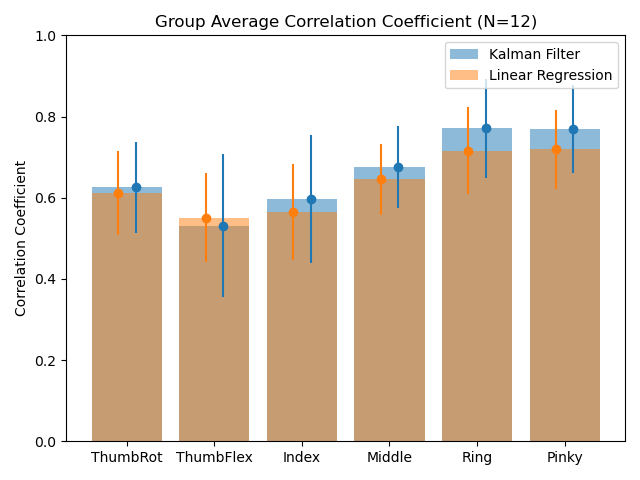

In [42]:
x_ticks = np.arange(len(df_stats.columns))
x_tick_labels = df_stats.columns

plt.figure()
plt.bar(x_ticks, df_stats.mean(0), label='Kalman Filter', alpha=0.5)
plt.errorbar(x_ticks+0.1, df_stats.mean(0), df_stats.std(0), fmt='o', color='C0', alpha=1.0)

plt.bar(x_ticks, df_stats_lr.mean(0), label='Linear Regression', alpha=0.5)
plt.errorbar(x_ticks-0.1, df_stats_lr.mean(0), df_stats_lr.std(0), fmt='o', color='C1', alpha=1.0)

plt.xticks(x_ticks, x_tick_labels)

plt.legend()

plt.ylim(0, 1)
plt.ylabel('Correlation Coefficient')
plt.title(f'Group Average Correlation Coefficient (N={len(df_stats)})')
plt.tight_layout()